# Besenius' Lab FRAP Analysis
**(with the 2D ImageJ Script by Marius)**


**How to use**

Go through each cell by Shift + Enter on your keyboard.

The first cell imports all necessary libraries and initializes required mathematical functions.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
from PIL import Image
import pandas as pd
from IPython.display import Javascript, display
from ipywidgets import widgets
import IPython

output = widgets.Output()
output1 = widgets.Output()


def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def linear_function(x, m, b):
    return m * x + b

def FindRoot(m,b):
    return -b/m

def FirstFit(ev):
    global initial_guess
    global df_transposed
    global x
    global y
    with output:
        output.clear_output()
        file_path = filename.value
        df = pd.read_csv(file_path)
        df_transposed = df.T
        df_transposed.columns = df_transposed.iloc[0]
        df_transposed = df_transposed[1:]
        print(f'Image Dimensions x Number of Frames: {df_transposed.shape}')
        df_transposed.iloc[:, :] = df_transposed.iloc[:, ::-1]
        df_transposed.columns = df_transposed.columns[::-1]
        df_transposed = -df_transposed
        x=np.arange(0,df_transposed.shape[0],1)

        y = df_transposed.iloc[:, 0].to_numpy() + 200
        plt.scatter(x,y)
        fit_params, _ = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *fit_params), 'k.', label=f'Fitted Gaussian')
        plt.title('Fitting Function First Frame')
        plt.xlabel('x (px)')
        plt.ylabel('Inverted Brightness (a.u.)')
        plt.show()
        initial_guess = fit_params
        
def GaussianFits(ev):
    global sigma
    global indices
    global A
    with output:
        i=0
        frame, std, amp = [],[],[]

        colormap = plt.cm.gist_ncar
        plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Set1(np.linspace(0, 1, 180))))

        for column in df_transposed.columns[0:180:1]:
            y = df_transposed[column].to_numpy() + 200
            fit_params, _ = curve_fit(gaussian, x, y)
            plt.plot(x, gaussian(x, *fit_params), label=f'Fitted Gaussian {column}')
            amplitude, mean, stddev = fit_params
            plt.title('Fitting Function All Frames')
            plt.xlabel('x (px)')
            plt.ylabel('Inverted Brightness (a.u.)')
    
            frame.append(i)
            std.append(stddev)
            amp.append(amplitude)

            i += 1
        plt.show()
    indices = np.array(frame)
    sigma = np.array(std)
    A = np.array(amp)

You can change the filename of the lineprofile.txt file. This file has to be uploaded to this directory (upload button on the left of your screen).

In [2]:
filename = widgets.Text(
    value='series44.tif_lineprofiles.txt',
    placeholder='Type something',
    description='Filename:',
    disabled=False   
)
display(filename)
output.clear_output()

button1 = widgets.Button(
    description='First Gaussian',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

button1.on_click(FirstFit)
hb1 = widgets.HBox([button1, output])


button2 = widgets.Button(
    description='Gaussian Fits',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
output.clear_output()  
button2.on_click(GaussianFits)
hb2 = widgets.HBox([button2, output])
buttons = widgets.VBox([button1, button2])
widgets.HBox([buttons, output])

Text(value='series44.tif_lineprofiles.txt', description='Filename:', placeholder='Type something')

In [3]:
def ShowSigma(change):
    new_value = change['new']
    fitting_range=linfitrange.value
    sigma_copy = sigma[fitting_range[0]:fitting_range[1]]
    indices_copy = indices[fitting_range[0]:fitting_range[1]]
    A_copy = A[fitting_range[0]:fitting_range[1]]
    params, covariance = curve_fit(linear_function, indices_copy, sigma_copy)
    m, b = params
    y_fit = linear_function(indices_copy, m, b)
    residuals = sigma_copy - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((sigma_copy - np.mean(sigma_copy))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    
    with output1:
        plt.xlabel('Time (s)')
        plt.gca().set_ylabel(r'$\sigma$ (px)')
        plt.title('Linear Fitting of Standard Deviation over Time')
        output1.clear_output()
        plt.scatter(indices_copy, sigma_copy, label='Original Data')
        plt.plot(indices_copy, y_fit, label=f'Linear Fit: y = {m:.2f}t + {b:.2f}\n$R^2$ = {r_squared:.2f}, $t_L$ = {FindRoot(m,b):.2f}', color='red')
        plt.legend()
        plt.show()
        
    log_indices = np.log(indices_copy)
    log_A = np.log(A_copy)
    nan_indices = np.isinf(log_indices)
    log_indices = log_indices[~nan_indices]
    log_A = log_A[~nan_indices]
    params, covariance = curve_fit(linear_function, log_indices, log_A)
    m, b = params
    y_fit = linear_function(log_indices, m, b)
    residuals = log_A - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((log_A - np.mean(log_A))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    with output1:
        plt.scatter(log_indices, log_A, label='Original Data')
        plt.plot(log_indices, y_fit, label=f'Linear Fit: log(A) = {m:.2f}log(t) + {b:.2f}\n$R^2$ = {r_squared:.2f}', color='red')
        plt.legend()
        plt.xlabel('log(t)')
        plt.ylabel('log(A)')
        plt.title('Linear Fitting of Amplitude over Time')
        plt.show()

linfitrange = widgets.IntRangeSlider(
    value=[0, 180],
    min=0,
    max=180,
    step=1,
    description='Range for Linear Fit:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
output1.clear_output()  
linfitrange.observe(ShowSigma, names='value')
widgets.HBox([linfitrange, output1])


Image Dimensions x Number of Frames: (255, 179)


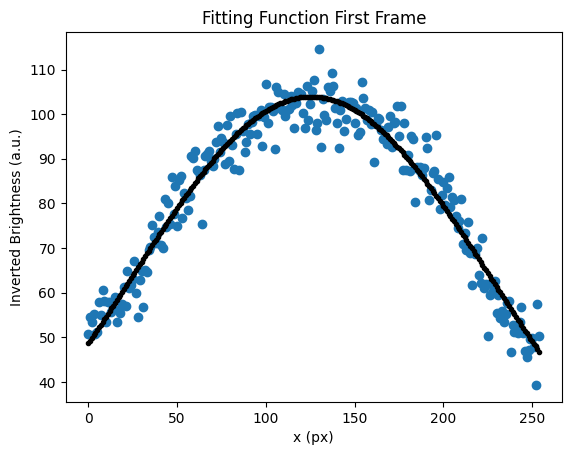

In [4]:
file_path = filename.value
df = pd.read_csv(file_path)
df_transposed = df.T
df_transposed.columns = df_transposed.iloc[0]
df_transposed = df_transposed[1:]
print(f'Image Dimensions x Number of Frames: {df_transposed.shape}')
df_transposed.iloc[:, :] = df_transposed.iloc[:, ::-1]
df_transposed.columns = df_transposed.columns[::-1]
df_transposed = -df_transposed
x=np.arange(0,df_transposed.shape[0],1)

y = df_transposed.iloc[:, 0].to_numpy() + 200
plt.scatter(x,y)
fit_params, _ = curve_fit(gaussian, x, y)
plt.plot(x, gaussian(x, *fit_params), 'k.', label=f'Fitted Gaussian')
plt.title('Fitting Function First Frame')
plt.xlabel('x (px)')
plt.ylabel('Inverted Brightness (a.u.)')

initial_guess = fit_params

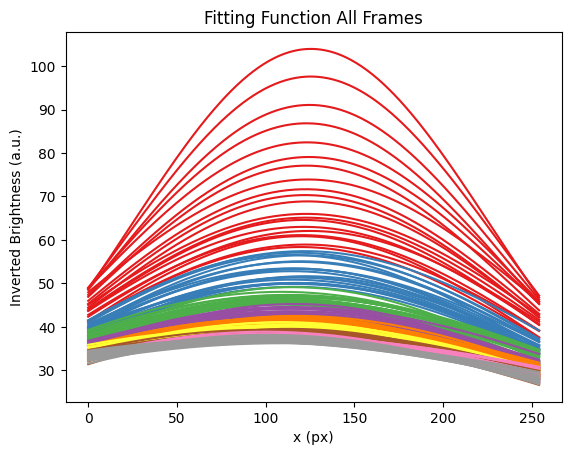

In [5]:
i=0
frame, std, amp = [],[],[]

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Set1(np.linspace(0, 1, 180))))

for column in df_transposed.columns[0:180:1]:
    #plt.plot(x,df_transposed[column], label=column)
    y = df_transposed[column].to_numpy() + 200
    fit_params, _ = curve_fit(gaussian, x, y)
    plt.plot(x, gaussian(x, *fit_params), label=f'Fitted Gaussian {column}')
    amplitude, mean, stddev = fit_params
    plt.title('Fitting Function All Frames')
    plt.xlabel('x (px)')
    plt.ylabel('Inverted Brightness (a.u.)')
    
    frame.append(i)
    std.append(stddev)
    amp.append(amplitude)

    i += 1
plt.show()
indices = np.array(frame)
sigma = np.array(std)
A = np.array(amp)

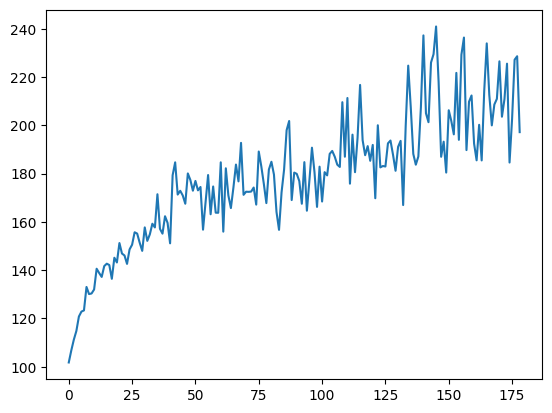

In [6]:
std_cleaned = []
amp_cleaned = []
for item in std:
    if item < 500:
        std_cleaned.append(item)
    else:
        pass
for item in amp:
    if item < 200:
        amp_cleaned.append(item)
plt.plot(frame, std)

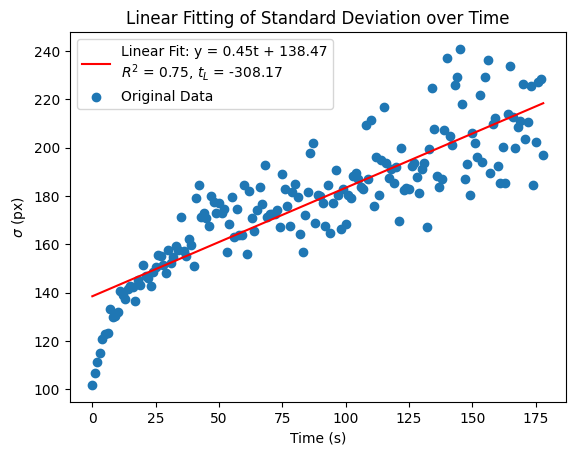

In [7]:
params, covariance = curve_fit(linear_function, indices, sigma)
m, b = params
y_fit = linear_function(indices, m, b)
residuals = sigma - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((sigma - np.mean(sigma))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.scatter(indices, sigma, label='Original Data')
plt.plot(indices, y_fit, label=f'Linear Fit: y = {m:.2f}t + {b:.2f}\n$R^2$ = {r_squared:.2f}, $t_L$ = {FindRoot(m,b):.2f}', color='red')
plt.legend()
plt.xlabel('Time (s)')
plt.gca().set_ylabel(r'$\sigma$ (px)')
plt.title('Linear Fitting of Standard Deviation over Time')
plt.show()

/var/folders/r7/3f8k14kd1yq3rnjcn0yy7nbm0000gn/T/ipykernel_74618/336342999.py:1: RuntimeWarning: divide by zero encountered in log
  log_indices = np.log(indices)


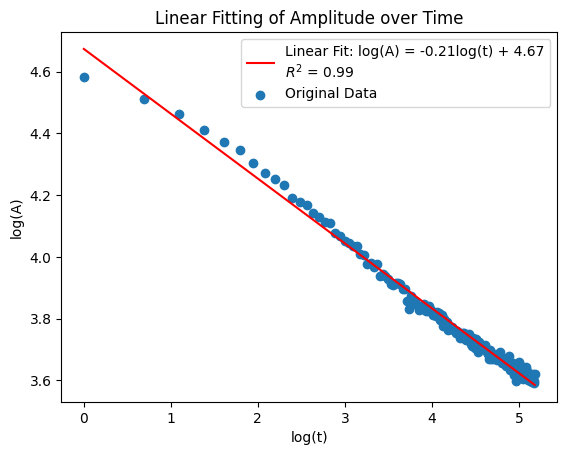

In [8]:
log_indices = np.log(indices)
log_A = np.log(A)
nan_indices = np.isinf(log_indices)
log_indices = log_indices[~nan_indices]
log_A = log_A[~nan_indices]
params, covariance = curve_fit(linear_function, log_indices, log_A)
m, b = params
y_fit = linear_function(log_indices, m, b)
residuals = log_A - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((log_A - np.mean(log_A))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.scatter(log_indices, log_A, label='Original Data')
plt.plot(log_indices, y_fit, label=f'Linear Fit: log(A) = {m:.2f}log(t) + {b:.2f}\n$R^2$ = {r_squared:.2f}', color='red')
plt.legend()
plt.xlabel('log(t)')
plt.ylabel('log(A)')
plt.title('Linear Fitting of Amplitude over Time')
plt.show()